# Fitting to the experimental data

In this notebook we will show how to load a CIF file, an experimental profile and how to perform a parameter fit.


#### Import Python packages

In [1]:
# esyScience, technique-independent
from easyCore import np
from easyCore.Fitting.Fitting import Fitter

# esyScience, diffraction
from easyDiffractionLib import Phases
from easyDiffractionLib.sample import Sample as Job
from easyDiffractionLib.interface import InterfaceFactory as Calculator
from easyDiffractionLib.Elements.Experiments.Pattern import Pattern1D
from easyDiffractionLib.Elements.Backgrounds.Point import PointBackground, BackgroundPoint
from easyDiffractionLib.Profiles.P1D import Instrument1DCWParameters as CWParams

# Vizualization
import py3Dmol
import matplotlib.pyplot as plt

GSAS-II binary directory: /Users/andrewsazonov/Development/Projects/easyScience/easyDiffraction/.venv/lib/python3.7/site-packages/GSASII/bindist
ImportError for wx/mpl in GSASIIctrlGUI: ignore if docs build


## --- Sample ---

#### Show a CIF file content

In [2]:
cif_fname = 'PbSO4.cif'

with open(cif_fname, 'r') as f:
    content = f.read()
    
print(content)

data_PbSO4

_space_group_name_H-M_alt   'P n m a'

_cell_length_a       8.480
_cell_length_b       5.398
_cell_length_c       6.958
_cell_angle_alpha   90.0
_cell_angle_beta    90.0
_cell_angle_gamma   90.0

loop_
 _atom_site_label
 _atom_site_type_symbol
 _atom_site_fract_x
 _atom_site_fract_y
 _atom_site_fract_z
 _atom_site_occupancy
 _atom_site_adp_type
 _atom_site_U_iso_or_equiv
  Pb  Pb   0.188   0.25   0.167   1.0   Uiso  0.01
  S   S    0.063   0.25   0.686   1.0   Uiso  0.01
  O1  O   -0.095   0.25   0.600   1.0   Uiso  0.01
  O2  O    0.181   0.25   0.543   1.0   Uiso  0.01
  O3  O    0.085   0.026  0.806   1.0   Uiso  0.01



#### Load structure from a CIF file

In [3]:
phases = Phases.from_cif_file(cif_fname)
phase = phases[0]

print(phases)
print(phase)

Collection of 1 phases.
Phase `PbSO4`


#### Visualise the structure

In [4]:
structure = py3Dmol.view()
structure.addModel(phase.to_cif_str(), 'cif')
structure.setStyle({'sphere':{'colorscheme':'Jmol','scale':.2},'stick':{'colorscheme':'Jmol','radius': 0.1}})
structure.addUnitCell()
structure.replicateUnitCell(2,2,1)
structure.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## --- Experiment ---

#### Show measured data as text

In [5]:
meas_fname = 'D1A@ILL.xye'

with open(meas_fname, 'r') as f:
    content = f.read()
    

print('\n'.join(content.split('\n')[:11]))

# PbSO4 D1A(ILL)(Rietveld Refinement Round Robin, R.J. Hill, JApC 25, 589 (1992)
       10.0000          220.0000         14.8324
       10.0500          214.0000         14.6287
       10.1000          219.0000         14.7986
       10.1500          224.0000         14.9666
       10.2000          198.0000         14.0712
       10.2500          229.0000         15.1327
       10.3000          224.0000         14.9666
       10.3500          216.0000         14.6969
       10.4000          202.0000         14.2127
       10.4500          229.0000         15.1327


#### Load the measured data

In [6]:
meas_x, meas_y, meas_e = np.loadtxt(meas_fname, unpack=True)

#### Visualize the measured data

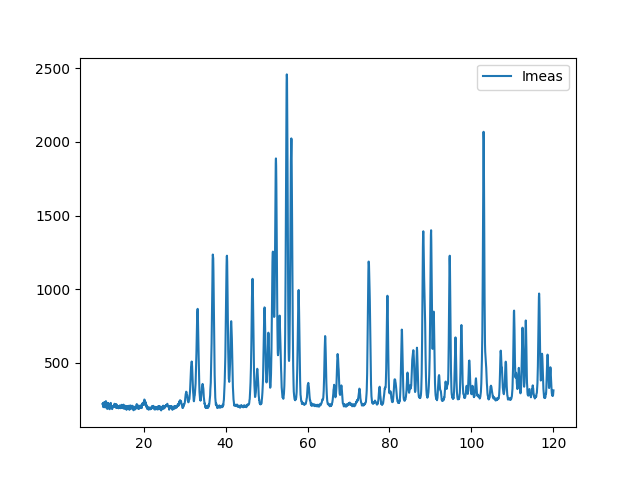

In [7]:
%matplotlib widget
plt.plot(meas_x, meas_y, label='Imeas')
plt.legend()

## --- Analysis ---

#### Create job with default parameters for the 1D powder neutron diffraction experiment with constant wavelength 

In [8]:
calculator = Calculator(interface_name='CrysPy')

In [9]:
print(f"Current calculator engine: {calculator.current_interface_name}")

Current calculator engine: CrysPy


In [10]:
job = Job(phases=phases, parameters=CWParams.default(), calculator=calculator)

Temp CIF: /var/folders/vj/bjjkqpsx4js6s242h0t_h45sf5f66_/T/easydiffraction_temp.cif


#### Generate the calculated data

In [11]:
calc_y_cryspy = calculator.fit_func(meas_x)

#### Visualize both the measured and calculated data

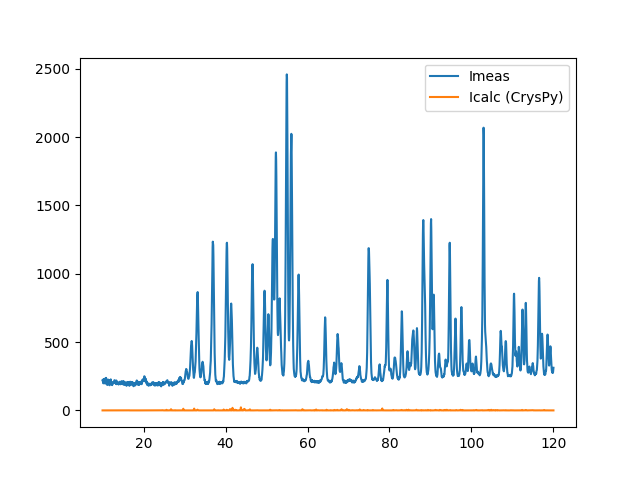

In [12]:
%matplotlib widget
plt.plot(meas_x, meas_y, label='Imeas')
plt.plot(meas_x, calc_y_cryspy, label='Icalc (CrysPy)')
plt.legend()

#### Set scale manually

In [13]:
job.pattern.scale = 100

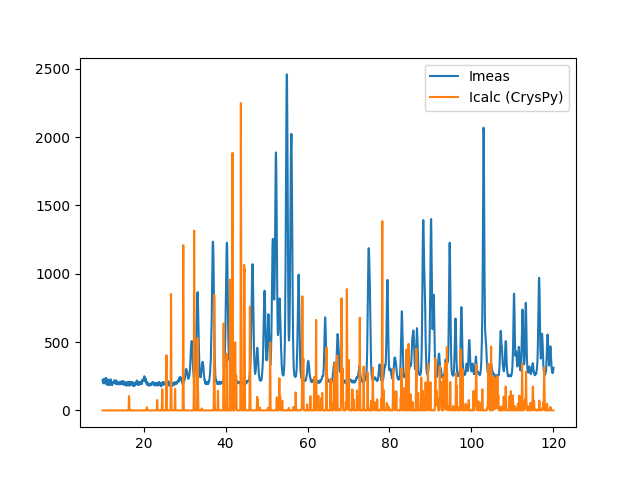

In [14]:
calc_y_cryspy = calculator.fit_func(meas_x)

%matplotlib widget
plt.plot(meas_x, meas_y, label='Imeas')
plt.plot(meas_x, calc_y_cryspy, label='Icalc (CrysPy)')
plt.legend()

#### Set wavelength manually

In [15]:
job.parameters.wavelength = 1.912

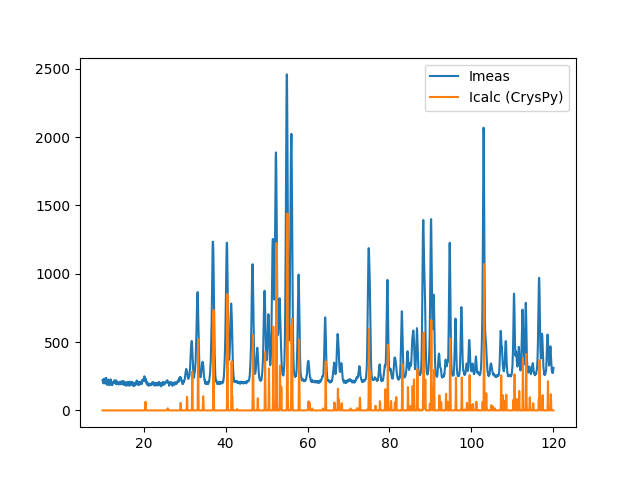

In [16]:
calc_y_cryspy = calculator.fit_func(meas_x)

%matplotlib widget
plt.plot(meas_x, meas_y, label='Imeas')
plt.plot(meas_x, calc_y_cryspy, label='Icalc (CrysPy)')
plt.legend()

#### Set background points manually

In [17]:
bkg = PointBackground(linked_experiment='PbSO4')

bkg.append(BackgroundPoint.from_pars(meas_x[0], 200))
bkg.append(BackgroundPoint.from_pars(meas_x[-1], 250))

job.set_background(bkg)

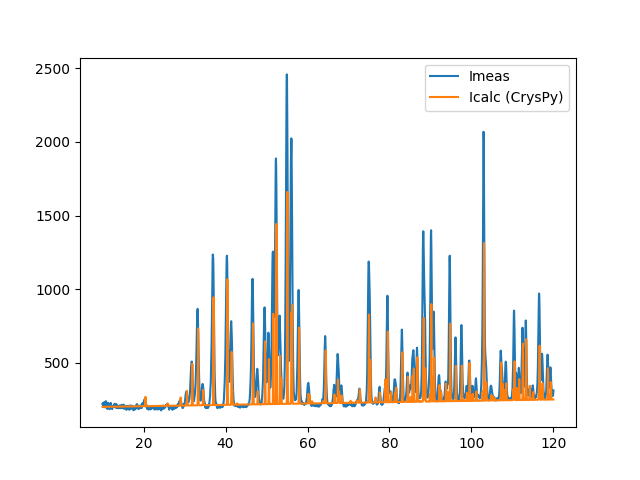

In [18]:
calc_y_cryspy = calculator.fit_func(meas_x)

%matplotlib widget
plt.plot(meas_x, meas_y, label='Imeas')
plt.plot(meas_x, calc_y_cryspy, label='Icalc (CrysPy)')
plt.legend()

#### Define parameters to optimize

In [19]:
job.pattern.scale.fixed = False
job.pattern.zero_shift.fixed = False
job.parameters.resolution_u.fixed = False
job.parameters.resolution_v.fixed = False
job.parameters.resolution_w.fixed = False
job.backgrounds[0][0].y.fixed = False
job.backgrounds[0][1].y.fixed = False

In [20]:
print(job.pattern.scale)
print(job.pattern.zero_shift)
print(job.parameters.resolution_u)
print(job.parameters.resolution_v)
print(job.parameters.resolution_w)
print(job.backgrounds[0][0])
print(job.backgrounds[0][1])

<Parameter 'scale': 100.0+/-0, bounds=[-inf:inf]>
<Parameter 'zero_shift': 0.0+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_u': 0.0002+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_v': -0.0002+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_w': 0.012+/-0, bounds=[-inf:inf]>
<BackgroundPoint '10,0_deg': 200.0+/-0, bounds=[-inf:inf]>
<BackgroundPoint '120,0_deg': 250.0+/-0, bounds=[-inf:inf]>


#### Initalize the fitting engine and perform the fit

In [21]:
fitter = Fitter(job, calculator.fit_func)

In [22]:
print(f"Available minimizers: {fitter.available_engines}")
print(f"Current minimizer: {fitter.current_engine.name}")
print(f"Available methods of current minimizers: {fitter.available_methods()}")

Available minimizers: ['lmfit', 'bumps', 'DFO_LS']
Current minimizer: lmfit
Available methods of current minimizers: ['least_squares', 'leastsq', 'differential_evolution', 'basinhopping', 'ampgo', 'nelder', 'lbfgsb', 'powell', 'cg', 'newton', 'cobyla', 'bfgs']


In [23]:
result = fitter.fit(meas_x, meas_y, weights=1/meas_e, 
                    method='least_squares', minimizer_kwargs={'diff_step': 1e-5})

In [24]:
print("The fit has been successful: {}".format(result.success))
if result.success:    
    print("The gooodness of fit (chi2) is: {}".format(result.reduced_chi))
    print(job.pattern.scale)
    print(job.pattern.zero_shift)
    print(job.parameters.resolution_u)
    print(job.parameters.resolution_v)
    print(job.parameters.resolution_w)
    print(job.backgrounds[0][0])
    print(job.backgrounds[0][1])

The fit has been successful: True
The gooodness of fit (chi2) is: 31.613447982827537
<Parameter 'scale': 600.5398381871566+/-0, bounds=[-inf:inf]>
<Parameter 'zero_shift': 0.1201919704485372+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_u': 0.18896561954669455+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_v': -0.4619806721233064+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_w': 0.47058462074654583+/-0, bounds=[-inf:inf]>
<BackgroundPoint '10,0_deg': 198.88369792542426+/-0, bounds=[-inf:inf]>
<BackgroundPoint '120,0_deg': 239.3945793845285+/-0, bounds=[-inf:inf]>


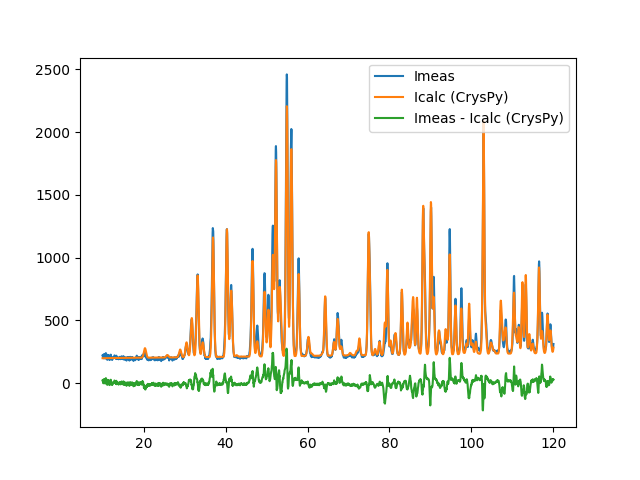

In [25]:
calc_y_cryspy = calculator.fit_func(meas_x)

%matplotlib widget
plt.plot(meas_x, meas_y, label='Imeas')
plt.plot(meas_x, calc_y_cryspy, label='Icalc (CrysPy)')
plt.plot(meas_x, meas_y-calc_y_cryspy, label='Imeas - Icalc (CrysPy)')
plt.legend()

#### Change calculator engine to CrysFML

In [26]:
print(f"Available calculator engines: {calculator.available_interfaces}")

Available calculator engines: ['CrysPy', 'CrysFML', 'GSASII']


In [27]:
job.interface.switch('CrysFML', fitter=fitter)

In [28]:
print(f"Current calculator engine: {job.interface.current_interface_name}")
print(f"Current minimizer: {fitter.current_engine.name}")

Current calculator engine: CrysFML
Current minimizer: lmfit


#### Show results of both CrysPy and CrysFML calculations (before fitting)

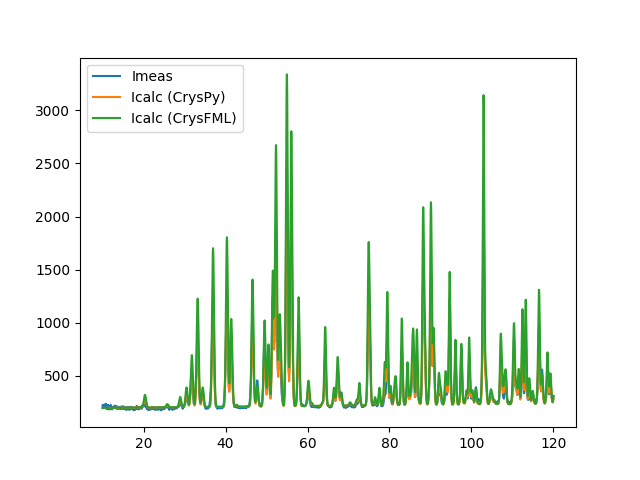

In [29]:
calc_y_crysfml = calculator.fit_func(meas_x)

%matplotlib widget
plt.plot(meas_x, meas_y, label='Imeas')
plt.plot(meas_x, calc_y_cryspy, label='Icalc (CrysPy)')
plt.plot(meas_x, calc_y_crysfml, label='Icalc (CrysFML)')
plt.legend()

#### Perform the fit with CrysFML

In [30]:
result = fitter.fit(meas_x, meas_y, weights=1/meas_e, 
                    method='least_squares', minimizer_kwargs={'diff_step': 1e-5})

In [31]:
print("The fit has been successful: {}".format(result.success))
if result.success:    
    print("The gooodness of fit (chi2) is: {}".format(result.reduced_chi))
    print(job.pattern.scale)
    print(job.pattern.zero_shift)
    print(job.parameters.resolution_u)
    print(job.parameters.resolution_v)
    print(job.parameters.resolution_w)
    print(job.backgrounds[0][0])
    print(job.backgrounds[0][1])

The fit has been successful: True
The gooodness of fit (chi2) is: 31.740148464580013
<Parameter 'scale': 381.94417054333036+/-0, bounds=[-inf:inf]>
<Parameter 'zero_shift': 0.12009617134564883+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_u': 0.17668662963914109+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_v': -0.4364532114851036+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_w': 0.46019227683829705+/-0, bounds=[-inf:inf]>
<BackgroundPoint '10,0_deg': 198.5227762103794+/-0, bounds=[-inf:inf]>
<BackgroundPoint '120,0_deg': 239.49472052013326+/-0, bounds=[-inf:inf]>


#### Show results of both CrysPy and CrysFML calculations (after fitting)

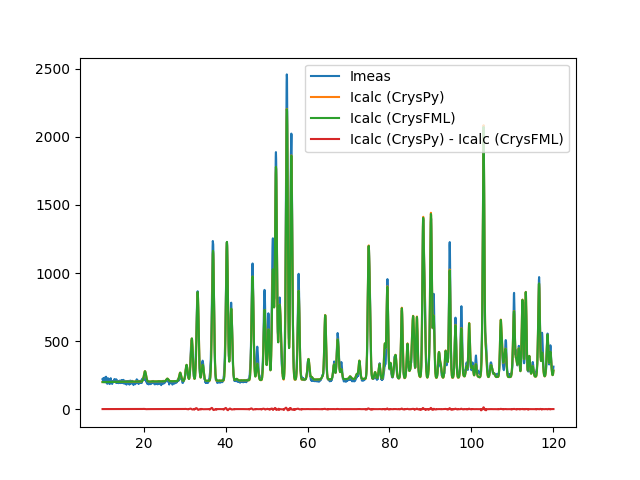

In [33]:
calc_y_crysfml = calculator.fit_func(meas_x)

%matplotlib widget
plt.plot(meas_x, meas_y, label='Imeas')
plt.plot(meas_x, calc_y_cryspy, label='Icalc (CrysPy)')
plt.plot(meas_x, calc_y_crysfml, label='Icalc (CrysFML)')
plt.plot(meas_x, calc_y_cryspy-calc_y_crysfml, label='Icalc (CrysPy) - Icalc (CrysFML)')
plt.legend()

#### Show the difference between CrysPy and CrysFML in calculated patterns

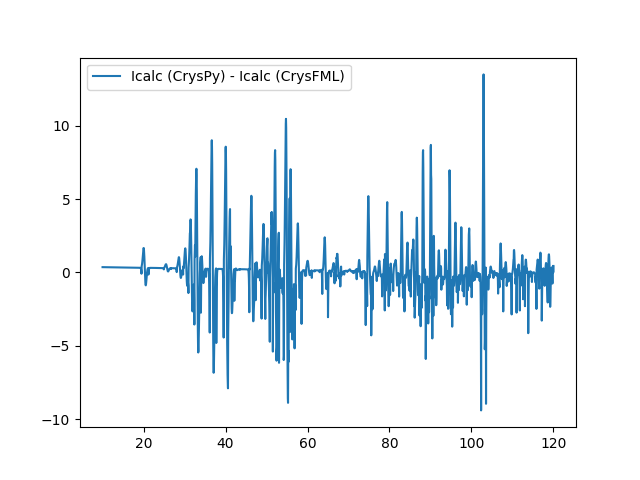

In [34]:
%matplotlib widget
plt.plot(meas_x, calc_y_cryspy-calc_y_crysfml, label='Icalc (CrysPy) - Icalc (CrysFML)')
plt.legend()